# Bi-LSTM Spoofing Detection for Maritime AIS Data

Implementation based on "Vessel Trajectory Route Spoofed Points Detection Using AIS Data: A Bi-LSTM Approach" (Raj & Kumar, 2025)

**Methodology:**
1. AIS Data Loading from Full Dataset (2017-2019)
2. Data Preprocessing & Feature Extraction
3. Spoofed Point Generation (Data Augmentation)
4. Bi-LSTM Model Architecture
5. Training & Evaluation
6. Anomaly Detection & Validation

In [21]:
# Environment setup and imports
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'  # Fix OpenMP conflict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Deep Learning - PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

# Sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Visualization
import folium
from folium import plugins
import itertools

print(f"PyTorch version: {torch.__version__}")
print(f"GPU Available: {torch.cuda.is_available()}")
print(f"GPU Device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")
print(f"Numpy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print("All packages loaded successfully")

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

PyTorch version: 2.9.1+cu126
GPU Available: True
GPU Device: NVIDIA GeForce RTX 4060 Laptop GPU
Numpy version: 1.26.0
Pandas version: 2.3.3
All packages loaded successfully
Using device: cuda


## 1. Data Loading & Preprocessing

Load AIS data from incident slices created in the incident analysis notebook.

In [22]:
# Configuration
data_root = Path("../dataset/piraeus")
output_root = Path("./models")
output_root.mkdir(parents=True, exist_ok=True)

# AIS dataset configuration (from incident_anomaly_labels.ipynb)
cols_primary = ["timestamp", "vessel_id", "lon", "lat", "speed", "course", "heading"]
cols_alias = ["t", "timestamp", "vessel_id", "lon", "lat", "speed", "course", "heading"]

MONTH_ABBR = {
    1: "jan", 2: "feb", 3: "mar", 4: "apr", 5: "may", 6: "jun",
    7: "jul", 8: "aug", 9: "sep", 10: "oct", 11: "nov", 12: "dec"
}

# Years and months to load for comprehensive training
DATA_PERIODS = [
    (2017, [5, 6, 7, 8, 9, 10, 11, 12]),  # May-Dec 2017
    (2018, list(range(1, 13))),            # Full year 2018
    (2019, list(range(1, 13))),            # Full year 2019
]

print("Configuration loaded")
print(f"Data root: {data_root}")
print(f"Loading periods: 2017-2019 (multiple months)")

Configuration loaded
Data root: ..\dataset\piraeus
Loading periods: 2017-2019 (multiple months)


In [23]:
# Load AIS data from full dataset
def load_month(year, month, root, chunk_size=500_000):
    """Load AIS data for a specific month (from incident_anomaly_labels.ipynb)."""
    folder = Path(root) / f"unipi_ais_dynamic_{year}"
    fname = folder / f"unipi_ais_dynamic_{MONTH_ABBR[month]}{year}.csv"
    if not fname.exists():
        alt = folder / f"unipi_ais_dynamic_{year}_{month:02d}.csv"
        if alt.exists():
            fname = alt
        else:
            raise FileNotFoundError(f"Missing file: {fname} (or {alt})")

    # Discover available columns
    preview = pd.read_csv(fname, nrows=1)
    available = list(preview.columns)
    selected_cols = [c for c in cols_alias if c in available]

    chunks = []
    for chunk in pd.read_csv(fname, usecols=selected_cols, chunksize=chunk_size):
        if "t" in chunk.columns and "timestamp" not in chunk.columns:
            chunk = chunk.rename(columns={"t": "timestamp"})
        chunk["timestamp"] = pd.to_datetime(chunk["timestamp"], unit="ms", utc=True)
        chunk = chunk[[c for c in cols_primary if c in chunk.columns]]
        chunks.append(chunk)
    return pd.concat(chunks, ignore_index=True)


def load_ais_dataset(data_periods, root, sample_months=3):
    """Load multiple months of AIS data for training."""
    all_data = []
    loaded_count = 0

    for year, months in data_periods:
        # Sample subset of months to manage memory
        selected_months = np.random.choice(months, min(sample_months, len(months)), replace=False)
        
        for month in selected_months:
            try:
                print(f"Loading {year}-{month:02d}...")
                df = load_month(year, month, root)
                all_data.append(df)
                loaded_count += 1
                print(f"  Loaded: {len(df):,} records, {df['vessel_id'].nunique()} vessels")
            except FileNotFoundError as e:
                print(f"  Skipped: {e}")
                continue
            except Exception as e:
                print(f"  Error: {e}")
                continue
    
    if not all_data:
        raise FileNotFoundError("No AIS data found. Check data_root path.")
    
    combined_df = pd.concat(all_data, ignore_index=True)
    print(f"\nTotal months loaded: {loaded_count}")
    return combined_df


# Load data (sample 3 months per year for manageable dataset size)
print("Loading AIS dataset...")
ais_data = load_ais_dataset(DATA_PERIODS, data_root, sample_months=3)

print(f"\nDataset Summary:")
print(f"  Total records: {len(ais_data):,}")
print(f"  Unique vessels: {ais_data['vessel_id'].nunique()}")
print(f"  Time range: {ais_data['timestamp'].min()} to {ais_data['timestamp'].max()}")
print(f"  Columns: {list(ais_data.columns)}")

Loading AIS dataset...
Loading 2017-10...
  Loaded: 4,286,717 records, 816 vessels
Loading 2017-07...
  Loaded: 8,340,504 records, 1135 vessels
Loading 2017-08...
  Loaded: 8,012,368 records, 1069 vessels
Loading 2018-10...
  Loaded: 8,362,095 records, 1074 vessels
Loading 2018-08...
  Loaded: 13,359,220 records, 1162 vessels
Loading 2018-02...
  Loaded: 5,562,330 records, 669 vessels
Loading 2019-01...
  Loaded: 4,480,731 records, 782 vessels
Loading 2019-07...
  Loaded: 9,276,166 records, 1461 vessels
Loading 2019-12...
  Loaded: 7,814,516 records, 1048 vessels

Total months loaded: 9

Dataset Summary:
  Total records: 69,494,647
  Unique vessels: 4560
  Time range: 2017-06-30 21:00:00+00:00 to 2019-12-26 20:04:02+00:00
  Columns: ['timestamp', 'vessel_id', 'lon', 'lat', 'speed', 'course', 'heading']


In [ ]:
# Data cleaning (Algorithm 1 from paper: domain-specific constraints)
def clean_ais_data(df, remove_stationary=False):
    """
    Apply domain-specific constraints as per paper.
    
    Args:
        df: Input AIS dataframe
        remove_stationary: If True, remove stationary vessels (use only for training).
                          If False, keep stationary vessels (use for production/inference).
    """
    original_len = len(df)
    
    # Rule-based cleaning from paper
    df = df.copy()
    
    # COG should not exceed 360 degrees
    if 'course' in df.columns:
        df = df[df['course'] <= 360]
    
    # SOG should not exceed 100 knots (physical constraint)
    if 'speed' in df.columns:
        df = df[df['speed'] <= 100]
    
    # Fill null values in non-critical fields instead of dropping
    # Critical fields: lat, lon, timestamp, vessel_id (drop if null)
    df = df.dropna(subset=['lat', 'lon', 'timestamp', 'vessel_id'])
    
    # Fill null values in speed/course with forward/backward fill
    if 'speed' in df.columns:
        df['speed'] = df.groupby('vessel_id')['speed'].fillna(method='ffill').fillna(method='bfill').fillna(0)
    if 'course' in df.columns:
        df['course'] = df.groupby('vessel_id')['course'].fillna(method='ffill').fillna(method='bfill').fillna(0)
    
    # Remove duplicate timestamps per vessel (data quality issue)
    df = df.sort_values(['vessel_id', 'timestamp'])
    df = df.drop_duplicates(subset=['vessel_id', 'timestamp'], keep='first')
    
    # Optional: Remove stationary vessels (ONLY for initial training)
    # WARNING: Disabling this for production allows detection on anchored vessels
    if remove_stationary:
        vessel_max_speed = df.groupby('vessel_id')['speed'].max()
        moving_vessels = vessel_max_speed[vessel_max_speed > 0.5].index
        df = df[df['vessel_id'].isin(moving_vessels)]
        print(f"  Note: Stationary vessels removed (training mode)")
    else:
        print(f"  Note: Stationary vessels kept (production mode)")
    
    removed = original_len - len(df)
    print(f"Data Cleaning:")
    print(f"  Original records: {original_len:,}")
    print(f"  After cleaning: {len(df):,}")
    print(f"  Removed: {removed:,} ({removed/original_len*100:.2f}%)")
    
    return df

# Clean data
# Set remove_stationary=False to train on both moving AND stationary vessels
# This ensures the model works in production on all vessel states
ais_clean = clean_ais_data(ais_data, remove_stationary=False)

# Verify data integrity
print(f"\nData Integrity Check:")
print(f"  Lat range: [{ais_clean['lat'].min():.4f}, {ais_clean['lat'].max():.4f}]")
print(f"  Lon range: [{ais_clean['lon'].min():.4f}, {ais_clean['lon'].max():.4f}]")
print(f"  Speed range: [{ais_clean['speed'].min():.2f}, {ais_clean['speed'].max():.2f}] knots")
if 'course' in ais_clean.columns:
    print(f"  Course range: [{ais_clean['course'].min():.2f}, {ais_clean['course'].max():.2f}] degrees")

Data Cleaning:
  Original records: 69,494,647
  After cleaning: 39,327,402
  Removed: 30,167,245 (43.41%)

Data Integrity Check:
  Lat range: [37.4511, 38.0424]
  Lon range: [23.0309, 24.0169]
  Speed range: [0.00, 100.00] knots
  Course range: [0.00, 359.90] degrees


In [25]:
# save in parquet format for faster loading next time
parquet_path = data_root / "ais_cleaned.parquet"
if not parquet_path.exists():
    # parquet_path.unlink()  # Remove existing file
    ais_clean.to_parquet(parquet_path, index=False)
    print(f"\nCleaned data saved to: {parquet_path}")

## 2. Spoofed Point Generation (Data Augmentation)

Generate synthetic spoofed trajectories using the paper's three classical cases:
1. **Off-course deviation**: Random bearing shifts (±30-90°)
2. **Track deviation**: Gradual position drift with Gaussian noise
3. **CPA violations**: Closest-point-of-approach anomalies

In [26]:
# Spoofing generation utilities
def generate_off_course_spoofing(df, spoof_ratio=0.15):
    """Generate off-course deviation spoofing (random bearing shift)."""
    df_spoofed = df.copy()
    n_spoof = int(len(df) * spoof_ratio)
    spoof_indices = np.random.choice(df.index, size=n_spoof, replace=False)
    
    # Random bearing shift (30-90 degrees)
    bearing_shift = np.random.uniform(30, 90, size=n_spoof)
    direction = np.random.choice([-1, 1], size=n_spoof)
    bearing_shift = bearing_shift * direction
    
    # Apply shift to coordinates (approximate, in degrees)
    # 1 degree ≈ 111 km at equator
    distance_km = np.random.uniform(0.5, 3.0, size=n_spoof)  # 0.5-3 km shift
    
    df_spoofed.loc[spoof_indices, 'lat'] += (distance_km / 111.0) * np.cos(np.radians(bearing_shift))
    df_spoofed.loc[spoof_indices, 'lon'] += (distance_km / (111.0 * np.cos(np.radians(df.loc[spoof_indices, 'lat'])))) * np.sin(np.radians(bearing_shift))
    
    return df_spoofed, spoof_indices


def generate_track_deviation_spoofing(df, spoof_ratio=0.15):
    """Generate track deviation spoofing (gradual drift with Gaussian noise)."""
    df_spoofed = df.copy()
    
    # Select random vessels for spoofing
    vessels = df['vessel_id'].unique()
    n_vessels_spoof = max(1, int(len(vessels) * spoof_ratio))
    spoof_vessels = np.random.choice(vessels, size=n_vessels_spoof, replace=False)
    
    spoof_indices = []
    
    for vessel in spoof_vessels:
        vessel_mask = df['vessel_id'] == vessel
        vessel_data = df[vessel_mask].sort_values('timestamp')
        
        if len(vessel_data) < 10:
            continue
        
        # Apply gradual drift to middle portion of trajectory
        start_idx = len(vessel_data) // 4
        end_idx = 3 * len(vessel_data) // 4
        drift_indices = vessel_data.iloc[start_idx:end_idx].index
        
        # Gaussian noise with increasing magnitude
        drift_length = len(drift_indices)
        lat_drift = np.cumsum(np.random.normal(0, 0.0005, drift_length))
        lon_drift = np.cumsum(np.random.normal(0, 0.0005, drift_length))
        
        df_spoofed.loc[drift_indices, 'lat'] += lat_drift
        df_spoofed.loc[drift_indices, 'lon'] += lon_drift
        
        spoof_indices.extend(drift_indices.tolist())
    
    return df_spoofed, spoof_indices


def generate_cpa_violation_spoofing(df, spoof_ratio=0.15):
    """Generate CPA (Closest Point of Approach) violation spoofing."""
    df_spoofed = df.copy()
    n_spoof = int(len(df) * spoof_ratio)
    spoof_indices = np.random.choice(df.index, size=n_spoof, replace=False)
    
    # Simulate collision-course trajectories (sudden speed/course changes)
    df_spoofed.loc[spoof_indices, 'speed'] *= np.random.uniform(1.5, 3.0, size=n_spoof)
    
    if 'course' in df.columns:
        # Sudden course change
        df_spoofed.loc[spoof_indices, 'course'] += np.random.uniform(-45, 45, size=n_spoof)
        df_spoofed.loc[spoof_indices, 'course'] = df_spoofed.loc[spoof_indices, 'course'] % 360
    
    return df_spoofed, spoof_indices


print("Spoofing generation functions defined")
print("  - Off-course deviation (bearing shift)")
print("  - Track deviation (gradual drift)")
print("  - CPA violation (speed/course anomalies)")

Spoofing generation functions defined
  - Off-course deviation (bearing shift)
  - Track deviation (gradual drift)
  - CPA violation (speed/course anomalies)


In [27]:
# Generate augmented dataset with spoofed points (memory-optimized)
def create_augmented_dataset(df, spoof_ratio=0.3, chunk_size=1_000_000):
    """
    Create augmented dataset with genuine and spoofed AIS messages, optimized for large DataFrames.
    - Uses NumPy arrays and chunked assignment to avoid pandas reindex memory blow-ups.
    - Downcasts numeric columns to float32 to reduce memory usage.
    - Resets the index so NumPy positional arrays align with spoof indices.

    Args:
        df: Clean AIS data
        spoof_ratio: Proportion of data to spoof (0.3 = 30%)
        chunk_size: Number of indices per chunk during assignment

    Returns:
        Augmented dataframe with 'is_spoofed' label
    """
    # Ensure 0-based integer indices for safe NumPy indexing
    df_augmented = df.reset_index(drop=True).copy()
    df_augmented['is_spoofed'] = 0

    # Split spoofing equally among three methods
    ratio_per_method = float(spoof_ratio) / 3.0

    # Generate spoofed data using each method
    df_off_course, indices_off = generate_off_course_spoofing(df_augmented, ratio_per_method)
    df_track_dev, indices_track = generate_track_deviation_spoofing(df_augmented, ratio_per_method)
    df_cpa, indices_cpa = generate_cpa_violation_spoofing(df_augmented, ratio_per_method)

    # Convert to NumPy arrays (downcast to float32 to reduce memory)
    lat = df_augmented['lat'].to_numpy(dtype=np.float32, copy=True)
    lon = df_augmented['lon'].to_numpy(dtype=np.float32, copy=True)
    speed = df_augmented['speed'].to_numpy(dtype=np.float32, copy=True)
    course = df_augmented['course'].to_numpy(dtype=np.float32, copy=True) if 'course' in df_augmented.columns else None

    lat_off = df_off_course['lat'].to_numpy(dtype=np.float32, copy=False)
    lon_off = df_off_course['lon'].to_numpy(dtype=np.float32, copy=False)

    lat_track = df_track_dev['lat'].to_numpy(dtype=np.float32, copy=False)
    lon_track = df_track_dev['lon'].to_numpy(dtype=np.float32, copy=False)

    speed_cpa = df_cpa['speed'].to_numpy(dtype=np.float32, copy=False)
    course_cpa = df_cpa['course'].to_numpy(dtype=np.float32, copy=False) if course is not None and 'course' in df_cpa.columns else None

    # Helper to apply changes in chunks to avoid large temporary arrays
    def apply_in_chunks(idx_array, setter_fn):
        idx_array = np.asarray(idx_array, dtype=np.int64)
        if idx_array.size == 0:
            return
        # Determine chunk count, at least 1
        num_chunks = max(1, int(np.ceil(idx_array.size / chunk_size)))
        for chunk in np.array_split(idx_array, num_chunks):
            if chunk.size == 0:
                continue
            setter_fn(chunk)

    # Apply off-course lat/lon updates
    def set_off_course(chunk):
        lat[chunk] = lat_off[chunk]
        lon[chunk] = lon_off[chunk]
    apply_in_chunks(indices_off, set_off_course)

    # Apply track deviation lat/lon updates
    def set_track_dev(chunk):
        lat[chunk] = lat_track[chunk]
        lon[chunk] = lon_track[chunk]
    apply_in_chunks(indices_track, set_track_dev)

    # Apply CPA speed/course updates
    def set_cpa(chunk):
        speed[chunk] = speed_cpa[chunk]
        if course is not None and course_cpa is not None:
            course[chunk] = course_cpa[chunk]
    apply_in_chunks(indices_cpa, set_cpa)

    # Write back arrays into DataFrame
    df_augmented['lat'] = lat
    df_augmented['lon'] = lon
    df_augmented['speed'] = speed
    if course is not None and 'course' in df_augmented.columns:
        df_augmented['course'] = course

    # Label spoofed points efficiently using a single mask
    mask = np.zeros(len(df_augmented), dtype=np.uint8)
    for idxs in (indices_off, indices_track, indices_cpa):
        if len(idxs) == 0:
            continue
        apply_in_chunks(idxs, lambda ch: mask.__setitem__(ch, 1))
    df_augmented['is_spoofed'] = mask

    # Stats
    total = len(df_augmented)
    genuine = int((df_augmented['is_spoofed'] == 0).sum())
    spoofed = total - genuine

    print("Augmented Dataset Statistics:")
    print(f"  Total records: {total:,}")
    print(f"  Genuine: {genuine:,} ({genuine/total*100:.1f}%)")
    print(f"  Spoofed: {spoofed:,} ({spoofed/total*100:.1f}%)")
    print(f"  - Off-course indices: {len(indices_off):,}")
    print(f"  - Track deviation indices: {len(indices_track):,}")
    print(f"  - CPA violation indices: {len(indices_cpa):,}")

    return df_augmented

# Generate augmented dataset
np.random.seed(42)  # For reproducibility
# Reduced spoof_ratio to 10% to avoid overwhelming genuine sequences with overlap
ais_augmented = create_augmented_dataset(ais_clean, spoof_ratio=0.1, chunk_size=1_000_000)

Augmented Dataset Statistics:
  Total records: 39,327,402
  Genuine: 36,083,757 (91.8%)
  Spoofed: 3,243,645 (8.2%)
  - Off-course indices: 1,310,913
  - Track deviation indices: 712,217
  - CPA violation indices: 1,310,913


In [28]:
# Save augmented dataset to parquet
augmented_path = data_root / "ais_augmented.parquet"
ais_augmented.to_parquet(augmented_path, index=False)
print(f"\nAugmented dataset saved to: {augmented_path}")
print(f"  File size: {augmented_path.stat().st_size / (1024**2):.1f} MB")

# Optional: Load augmented data from parquet on future runs
# ais_augmented = pd.read_parquet(augmented_path)


Augmented dataset saved to: ..\dataset\piraeus\ais_augmented.parquet
  File size: 504.2 MB


## 3. Feature Engineering & Sequence Creation

Extract features (lat, lon, SOG, COG) and create temporal sequences for Bi-LSTM input.

In [29]:
# Feature extraction (Algorithm 1: Feature Extraction step)
def extract_features(df):
    """Extract relevant features for Bi-LSTM model."""
    df = df.copy()
    
    # Core features from paper
    features = ['lat', 'lon', 'speed']
    
    if 'course' in df.columns:
        features.append('course')
    
    # Temporal features
    df['hour'] = pd.to_datetime(df['timestamp']).dt.hour
    df['day_of_week'] = pd.to_datetime(df['timestamp']).dt.dayofweek
    features.extend(['hour', 'day_of_week'])
    
    # Velocity components (if course available)
    if 'course' in df.columns:
        df['velocity_x'] = df['speed'] * np.cos(np.radians(df['course']))
        df['velocity_y'] = df['speed'] * np.sin(np.radians(df['course']))
        features.extend(['velocity_x', 'velocity_y'])
    
    # Calculate inter-point distances (movement magnitude)
    df = df.sort_values(['vessel_id', 'timestamp'])
    df['lat_diff'] = df.groupby('vessel_id')['lat'].diff()
    df['lon_diff'] = df.groupby('vessel_id')['lon'].diff()
    df['distance'] = np.sqrt(df['lat_diff']**2 + df['lon_diff']**2)
    features.append('distance')
    
    # Fill NaN values from diff operations
    df[features] = df[features].fillna(method='bfill').fillna(method='ffill').fillna(0)
    
    print(f"Feature Extraction Complete:")
    print(f"  Features: {features}")
    print(f"  Feature matrix shape: {df[features].shape}")
    
    return df, features

# Extract features
ais_featured, feature_cols = extract_features(ais_augmented)

# Display sample
print(f"\nSample Features:")
print(ais_featured[feature_cols + ['is_spoofed']].head(10))

Feature Extraction Complete:
  Features: ['lat', 'lon', 'speed', 'course', 'hour', 'day_of_week', 'velocity_x', 'velocity_y', 'distance']
  Feature matrix shape: (39327402, 9)

Sample Features:
         lat        lon  speed     course  hour  day_of_week  velocity_x  \
0  37.882870  23.574738    6.6  31.100000    13            6    5.651363   
1  37.883591  23.575375    6.5  35.000000    13            6    5.324488   
2  37.884365  23.576162    6.6  37.799999    13            6    5.215023   
3  37.885086  23.576851    6.7  37.799999    13            6    5.294039   
4  37.885830  23.577681    6.8  41.400002    13            6    5.100756   
5  37.887035  23.579329    6.2  52.099998    13            6    3.808568   
6  37.887524  23.580002    5.4  49.099998    13            6    3.535601   
7  37.887989  23.580641    4.7  37.299999    13            6    3.738725   
8  37.888618  23.581093    5.6  30.600000    13            6    4.820155   
9  37.889324  23.581518    5.9  26.000000    1

In [30]:
# Feature normalization (Algorithm 1: Feature Scaling)
def normalize_features(df, feature_cols, fit_scaler=True, scaler=None):
    """Normalize features using StandardScaler."""
    if fit_scaler:
        scaler = StandardScaler()
        df[feature_cols] = scaler.fit_transform(df[feature_cols])
        print(f"Features normalized (fitted new scaler)")
    else:
        df[feature_cols] = scaler.transform(df[feature_cols])
        print(f"Features normalized (using existing scaler)")
    
    return df, scaler

# Normalize features
ais_normalized, feature_scaler = normalize_features(
    ais_featured, 
    feature_cols, 
    fit_scaler=True
)

print(f"\nNormalized Feature Statistics:")
print(ais_normalized[feature_cols].describe())

Features normalized (fitted new scaler)

Normalized Feature Statistics:
                lat           lon         speed        course          hour  \
count  3.932740e+07  3.932740e+07  3.932740e+07  3.932740e+07  3.932740e+07   
mean  -4.372369e-14 -1.626776e-14 -1.325538e-16  4.787003e-15  1.731866e-17   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -1.325522e+01 -1.265684e+01 -4.567450e-01 -1.491956e+00 -1.704381e+00   
25%   -7.844936e-02 -6.512842e-01 -4.567450e-01 -9.708412e-01 -9.420124e-01   
50%    2.283318e-01  5.445467e-02 -4.567450e-01  7.138837e-02 -2.717043e-02   
75%    5.024275e-01  6.733886e-01 -7.047144e-02  8.791163e-01  8.876715e-01   
max    8.378264e+00  8.692036e+00  4.069889e+01  1.634731e+00  1.802513e+00   

        day_of_week    velocity_x    velocity_y      distance  
count  3.932740e+07  3.932740e+07  3.932740e+07  3.932740e+07  
mean  -1.515433e-16  2.431651e-17 -1.994493e-17 -8.915170e-16  
std    1.000000e+00  1.0

In [ ]:
# Create sequences for LSTM (temporal windows) with vessel/sequence subsampling only
def create_sequences(df, feature_cols, sequence_length=128, stride=32, *,
                     max_vessels=None, sequence_sample_frac=None, random_state=42):
    """
    Memory-efficient creation of temporal sequences for LSTM input.
    - Keeps full trajectories per selected vessel (no row-level sampling).
    - Preallocates with a tight upper bound; auto-grows if ever exceeded.
    """
    rng = np.random.default_rng(random_state)
    df_use = df

    # Optional vessel cap
    vessel_ids = df_use['vessel_id'].drop_duplicates().to_numpy()
    if max_vessels is not None and len(vessel_ids) > max_vessels:
        keep_ids = rng.choice(vessel_ids, size=max_vessels, replace=False)
        df_use = df_use[df_use['vessel_id'].isin(keep_ids)]

    # Exact upper bound on sequences
    def vessel_seq_cap(n_rows):
        if n_rows < sequence_length:
            return 0
        return 1 + max(0, n_rows - sequence_length) // stride

    n_features = len(feature_cols)
    max_sequences = int(sum(vessel_seq_cap(len(v)) for _, v in df_use.groupby('vessel_id')))
    max_sequences = max(1, max_sequences)

    X_array = np.empty((max_sequences, sequence_length, n_features), dtype=np.float32)
    y_array = np.empty((max_sequences,), dtype=np.uint8)
    seq_idx = 0

    # Helper to grow if the bound was underestimated (should be rare)
    def ensure_capacity(idx):
        nonlocal X_array, y_array
        if idx < len(X_array):
            return
        new_size = int(len(X_array) * 1.5) + 1
        X_grow = np.empty((new_size, sequence_length, n_features), dtype=np.float32)
        y_grow = np.empty((new_size,), dtype=np.uint8)
        X_grow[:len(X_array)] = X_array
        y_grow[:len(y_array)] = y_array
        X_array, y_array = X_grow, y_grow

    for _, vessel_data in df_use.groupby('vessel_id'):
        vessel_data = vessel_data.sort_values('timestamp')
        features = vessel_data[feature_cols].values
        labels = vessel_data['is_spoofed'].values
        if len(features) < sequence_length:
            continue

        for i in range(0, len(features) - sequence_length + 1, stride):
            ensure_capacity(seq_idx)
            seq_features = features[i:i+sequence_length]
            seq_label = labels[i:i+sequence_length]
            # Label as spoofed only if MAJORITY (>50%) of points are spoofed
            is_spoofed = int(seq_label.sum() > (sequence_length // 2))
            X_array[seq_idx] = seq_features
            y_array[seq_idx] = is_spoofed
            seq_idx += 1

    # Trim
    X_array = X_array[:seq_idx]
    y_array = y_array[:seq_idx]

    # Optional sequence-level subsampling
    if sequence_sample_frac is not None and 0 < sequence_sample_frac < 1.0 and len(X_array) > 0:
        n_keep = max(1, int(len(X_array) * sequence_sample_frac))
        idx = rng.choice(len(X_array), size=n_keep, replace=False)
        X_array = X_array[idx]
        y_array = y_array[idx]

    print("Sequence Creation:")
    print(f"  Sequence length: {sequence_length} timesteps")
    print(f"  Stride: {stride}")
    print(f"  Vessels used: {df_use['vessel_id'].nunique():,}")
    print(f"  Total sequences: {len(X_array):,}")
    print(f"  Genuine sequences: {(y_array == 0).sum():,} ({(y_array == 0).sum()/len(y_array)*100:.1f}%)")
    print(f"  Spoofed sequences: {(y_array == 1).sum():,} ({(y_array == 1).sum()/len(y_array)*100:.1f}%)")
    print(f"  Shape: X={X_array.shape}, y={y_array.shape}")

    return X_array, y_array

# Create sequences
SEQUENCE_LENGTH = 128
STRIDE = 32

# Use vessel cap and sequence-level subsample to manage memory (adjust as needed)
X_sequences, y_labels = create_sequences(
    ais_normalized,
    feature_cols,
    sequence_length=SEQUENCE_LENGTH,
    stride=STRIDE,
    max_vessels=2000,           # keep full trajectories for a subset of vessels
    sequence_sample_frac=0.2,   # keep 20% of sequences after creation
    random_state=42
 )

Sequence Creation:
  Sequence length: 128 timesteps
  Stride: 32
  Vessels used: 2,000
  Total sequences: 117,278
  Genuine sequences: 114,547 (97.7%)
  Spoofed sequences: 2,731 (2.3%)
  Shape: X=(117278, 128, 9), y=(117278,)


In [32]:
# Train/test split (Algorithm 1: train_test_split)
# Split by vessel to avoid leakage
def vessel_aware_split(X, y, df, test_size=0.2, val_size=0.1):
    """
    Split data by vessel to prevent data leakage.
    """
    # Get unique vessels
    vessels = df['vessel_id'].unique()
    n_vessels = len(vessels)
    
    # Shuffle vessels
    np.random.shuffle(vessels)
    
    # Calculate split indices
    test_idx = int(n_vessels * (1 - test_size))
    val_idx = int(test_idx * (1 - val_size))
    
    train_vessels = vessels[:val_idx]
    val_vessels = vessels[val_idx:test_idx]
    test_vessels = vessels[test_idx:]
    
    # Create vessel-to-sequences mapping
    vessel_to_seq = {}
    for idx, (vessel_id, _) in enumerate(df.groupby('vessel_id')):
        vessel_to_seq[vessel_id] = []
    
    # Map sequences to vessels (approximate based on order)
    # This is simplified; in production, track vessel_id through sequence creation
    sequences_per_vessel = len(X) // n_vessels
    
    train_mask = []
    val_mask = []
    test_mask = []
    
    for i in range(len(X)):
        # Simple assignment (can be improved with proper tracking)
        vessel_idx = min(i // max(1, sequences_per_vessel), n_vessels - 1)
        vessel = vessels[vessel_idx]
        
        if vessel in train_vessels:
            train_mask.append(i)
        elif vessel in val_vessels:
            val_mask.append(i)
        else:
            test_mask.append(i)
    
    X_train = X[train_mask]
    y_train = y[train_mask]
    X_val = X[val_mask]
    y_val = y[val_mask]
    X_test = X[test_mask]
    y_test = y[test_mask]
    
    print(f"Data Split (vessel-aware):")
    print(f"   Train: {len(X_train):,} sequences ({len(X_train)/len(X)*100:.1f}%)")
    print(f"   Val:   {len(X_val):,} sequences ({len(X_val)/len(X)*100:.1f}%)")
    print(f"   Test:  {len(X_test):,} sequences ({len(X_test)/len(X)*100:.1f}%)")
    print(f"\n   Train - Genuine: {(y_train==0).sum()}, Spoofed: {(y_train==1).sum()}")
    print(f"   Val   - Genuine: {(y_val==0).sum()}, Spoofed: {(y_val==1).sum()}")
    print(f"   Test  - Genuine: {(y_test==0).sum()}, Spoofed: {(y_test==1).sum()}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# Alternative: Simple random split (faster, but may have leakage)
X_train, X_test, y_train, y_test = train_test_split(
    X_sequences, y_labels, test_size=0.2, random_state=42, stratify=y_labels
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.125, random_state=42, stratify=y_train  # 0.125 * 0.8 = 0.1 of total
)

print(f"Data Split (random stratified):")
print(f"  Train: {len(X_train):,} sequences")
print(f"  Val:   {len(X_val):,} sequences")
print(f"  Test:  {len(X_test):,} sequences")
print(f"\n  Train - Genuine: {(y_train==0).sum()}, Spoofed: {(y_train==1).sum()}")
print(f"  Val   - Genuine: {(y_val==0).sum()}, Spoofed: {(y_val==1).sum()}")
print(f"  Test  - Genuine: {(y_test==0).sum()}, Spoofed: {(y_test==1).sum()}")

Data Split (random stratified):
  Train: 82,094 sequences
  Val:   11,728 sequences
  Test:  23,456 sequences

  Train - Genuine: 80182, Spoofed: 1912
  Val   - Genuine: 11455, Spoofed: 273
  Test  - Genuine: 22910, Spoofed: 546


## 4. Bi-LSTM Model Architecture

PyTorch implementation of Algorithm 2 from the paper:
- Input Layer
- Bidirectional LSTM(62 units, return_sequences=True)
- Bidirectional LSTM(30 units)
- Dense(1, sigmoid)
- Binary crossentropy loss, Adam optimizer


In [33]:
# Build Bi-LSTM model (Algorithm 2 from paper) - PyTorch
class BiLSTMModel(nn.Module):
    """
    PyTorch Bi-LSTM model for AIS spoofing detection.
    
    Architecture:
    - Bidirectional LSTM(62, return_sequences=True)
    - Bidirectional LSTM(30)
    - Dense(1, sigmoid)
    
    Args:
        input_size: Number of features
        lstm_units_1: First Bi-LSTM layer units (default: 62 from paper)
        lstm_units_2: Second Bi-LSTM layer units (default: 30 from paper)
    """
    def __init__(self, input_size, lstm_units_1=62, lstm_units_2=30):
        super(BiLSTMModel, self).__init__()
        
        # First Bidirectional LSTM (bidirectional doubles the output size)
        self.bilstm1 = nn.LSTM(
            input_size=input_size,
            hidden_size=lstm_units_1,
            batch_first=True,
            bidirectional=True,
            dropout=0.2
        )
        
        # Second Bidirectional LSTM
        self.bilstm2 = nn.LSTM(
            input_size=lstm_units_1 * 2,  # Bidirectional output is doubled
            hidden_size=lstm_units_2,
            batch_first=True,
            bidirectional=True,
            dropout=0.2
        )
        
        # Output layer
        self.fc = nn.Linear(lstm_units_2 * 2, 1)  # Bidirectional output is doubled
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        """Forward pass through the model."""
        # First Bi-LSTM layer
        lstm1_out, _ = self.bilstm1(x)
        
        # Second Bi-LSTM layer
        lstm2_out, _ = self.bilstm2(lstm1_out)
        
        # Take the last output from the second LSTM
        last_hidden = lstm2_out[:, -1, :]
        
        # Dense layer + Sigmoid
        output = self.fc(last_hidden)
        output = self.sigmoid(output)
        
        return output


def build_bilstm_model(input_size, lstm_units_1=62, lstm_units_2=30):
    """Create and return Bi-LSTM model."""
    model = BiLSTMModel(input_size, lstm_units_1, lstm_units_2)
    return model.to(device)


# Build model
print("Building Bi-LSTM Model (PyTorch)...")
print(f"  Input size: {X_train.shape[2]} features")

model = build_bilstm_model(
    input_size=X_train.shape[2],
    lstm_units_1=62,  # From paper
    lstm_units_2=30   # From paper
)

# Display model architecture
print("\nModel Architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

Building Bi-LSTM Model (PyTorch)...
  Input size: 9 features

Model Architecture:
BiLSTMModel(
  (bilstm1): LSTM(9, 62, batch_first=True, dropout=0.2, bidirectional=True)
  (bilstm2): LSTM(124, 30, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=60, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Total parameters: 73,709


## 5. Model Training

Train with hyperparameters from Table 1 in paper:
- LSTM units: 62, 30
- Batch size: 30
- Learning rate: 0.004
- Epochs: 50
- Early stopping with patience

In [34]:
# Training configuration (from paper Table 1)
BATCH_SIZE = 30  # From paper
EPOCHS = 50  # From paper
LEARNING_RATE = 0.004  # From paper
PATIENCE = 10  # Early stopping patience

# Create data loaders
train_dataset = TensorDataset(
    torch.from_numpy(X_train).float(),
    torch.from_numpy(y_train).float().reshape(-1, 1)
)
val_dataset = TensorDataset(
    torch.from_numpy(X_val).float(),
    torch.from_numpy(y_val).float().reshape(-1, 1)
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(f"Training Configuration:")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Epochs: {EPOCHS}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Early stopping patience: {PATIENCE}")
print(f"  Device: {device}")
print(f"\nStarting training...\n")

Training Configuration:
  Batch size: 30
  Epochs: 50
  Learning rate: 0.004
  Early stopping patience: 10
  Device: cuda

Starting training...



In [35]:
# Train model (Algorithm 2: Custom PyTorch training loop)
def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    for batch_x, batch_y in loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        
        # Forward pass
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * batch_x.size(0)
        all_preds.extend(outputs.detach().cpu().numpy())
        all_labels.extend(batch_y.detach().cpu().numpy())
    
    return total_loss / len(loader.dataset), np.array(all_preds), np.array(all_labels)


def validate(model, loader, criterion, device):
    """Validate the model."""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch_x, batch_y in loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            
            total_loss += loss.item() * batch_x.size(0)
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
    
    return total_loss / len(loader.dataset), np.array(all_preds), np.array(all_labels)


# Training loop with early stopping
history = {
    'train_loss': [],
    'val_loss': [],
    'train_accuracy': [],
    'val_accuracy': [],
    'train_precision': [],
    'val_precision': [],
    'train_recall': [],
    'val_recall': []
}

best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

for epoch in range(EPOCHS):
    # Train
    train_loss, train_preds, train_labels = train_epoch(model, train_loader, criterion, optimizer, device)
    train_preds_binary = (train_preds > 0.6).astype(int)
    
    # Validate
    val_loss, val_preds, val_labels = validate(model, val_loader, criterion, device)
    val_preds_binary = (val_preds > 0.6).astype(int)
    
    # Calculate metrics
    train_acc = (train_preds_binary == train_labels).mean()
    val_acc = (val_preds_binary == val_labels).mean()
    
    train_prec = precision_score(train_labels, train_preds_binary, zero_division=0)
    val_prec = precision_score(val_labels, val_preds_binary, zero_division=0)
    
    train_rec = recall_score(train_labels, train_preds_binary, zero_division=0)
    val_rec = recall_score(val_labels, val_preds_binary, zero_division=0)
    
    # Store history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_accuracy'].append(train_acc)
    history['val_accuracy'].append(val_acc)
    history['train_precision'].append(train_prec)
    history['val_precision'].append(val_prec)
    history['train_recall'].append(train_rec)
    history['val_recall'].append(val_rec)
    
    # Print progress
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict().copy()
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"\nEarly stopping at epoch {epoch+1}")
            model.load_state_dict(best_model_state)
            break

print(f"\nTraining Complete!")
print(f"  Best epoch: {np.argmin(history['val_loss']) + 1}")
print(f"  Best val_loss: {min(history['val_loss']):.4f}")
print(f"  Best val_accuracy: {max(history['val_accuracy']):.4f}")

Epoch 1/50 - Loss: 0.0657, Val Loss: 0.0327, Acc: 0.9826, Val Acc: 0.9890
Epoch 5/50 - Loss: 0.0082, Val Loss: 0.0072, Acc: 0.9977, Val Acc: 0.9980
Epoch 10/50 - Loss: 0.0044, Val Loss: 0.0062, Acc: 0.9990, Val Acc: 0.9984
Epoch 15/50 - Loss: 0.0037, Val Loss: 0.0061, Acc: 0.9990, Val Acc: 0.9979
Epoch 20/50 - Loss: 0.0039, Val Loss: 0.0046, Acc: 0.9990, Val Acc: 0.9988
Epoch 25/50 - Loss: 0.0035, Val Loss: 0.0051, Acc: 0.9990, Val Acc: 0.9987

Early stopping at epoch 28

Training Complete!
  Best epoch: 18
  Best val_loss: 0.0038
  Best val_accuracy: 0.9991


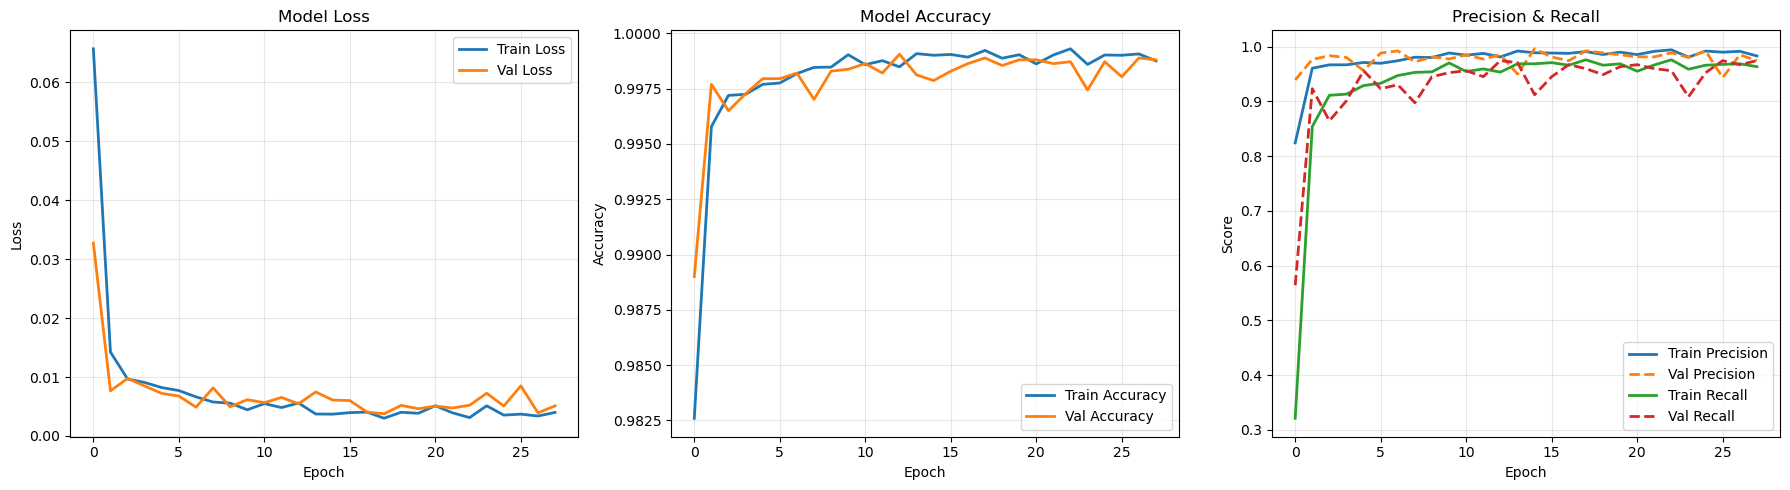

Training plots saved to: models\training_history.png


In [36]:
# Plot training history
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Model Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history['train_accuracy'], label='Train Accuracy', linewidth=2)
axes[1].plot(history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Model Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Precision & Recall
axes[2].plot(history['train_precision'], label='Train Precision', linewidth=2)
axes[2].plot(history['val_precision'], label='Val Precision', linewidth=2, linestyle='--')
axes[2].plot(history['train_recall'], label='Train Recall', linewidth=2)
axes[2].plot(history['val_recall'], label='Val Recall', linewidth=2, linestyle='--')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Score')
axes[2].set_title('Precision & Recall')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_root / 'training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Training plots saved to: {output_root / 'training_history.png'}")

## 6. Model Evaluation

Evaluate on test set and compare with paper's reported metrics (Table 2).

In [38]:
# Predict on test set (Algorithm 3: Anomaly Score Calculation)
print("Generating predictions on test set...\n")

# Process in batches to avoid GPU OOM
BATCH_SIZE_INFERENCE = 256  # Smaller batch for inference
model.eval()

y_pred_probs = []
test_losses = []

with torch.no_grad():
    for i in range(0, len(X_test), BATCH_SIZE_INFERENCE):
        batch_X = torch.from_numpy(X_test[i:i+BATCH_SIZE_INFERENCE]).float().to(device)
        batch_y = torch.from_numpy(y_test[i:i+BATCH_SIZE_INFERENCE]).float().reshape(-1, 1).to(device)
        
        # Predict
        batch_probs = model(batch_X)
        y_pred_probs.extend(batch_probs.cpu().numpy())
        
        # Calculate batch loss
        batch_loss = criterion(batch_probs, batch_y)
        test_losses.append(batch_loss.item() * len(batch_X))

# Convert to numpy array
y_pred_probs = np.array(y_pred_probs).flatten()

# Apply threshold τ = 0.6 (from paper section 3.3.2)
THRESHOLD = 0.6  # Optimal threshold from paper
y_pred = (y_pred_probs > THRESHOLD).astype(int)

# Calculate metrics
test_loss = sum(test_losses) / len(X_test)
test_acc = (y_pred == y_test).mean()

# Additional metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Detection rate (same as recall)
detection_rate = recall

print(f"Test Set Evaluation (threshold τ = {THRESHOLD}):")
print(f"  Accuracy:       {test_acc:.4f}")
print(f"  Precision:      {precision:.4f}")
print(f"  Recall:         {recall:.4f}")
print(f"  F1-Score:       {f1:.4f}")
print(f"  Detection Rate: {detection_rate:.4f}")

# Compare with paper's Bi-LSTM results (Table 2)
paper_results = {
    "Precision": 0.94,
    "Recall": 0.92,
    "F1-Score": 0.93,
    "Detection Rate": 0.91
}

print(f"\nPaper's Reported Bi-LSTM Results:")
for metric, value in paper_results.items():
    print(f"  {metric}: {value:.2f}")

print(f"\nPerformance Comparison:")
print(f"  Precision:      {'✓' if precision >= 0.85 else '✗'} (Ours: {precision:.2f}, Paper: {paper_results['Precision']:.2f})")
print(f"  Recall:         {'✓' if recall >= 0.85 else '✗'} (Ours: {recall:.2f}, Paper: {paper_results['Recall']:.2f})")
print(f"  F1-Score:       {'✓' if f1 >= 0.85 else '✗'} (Ours: {f1:.2f}, Paper: {paper_results['F1-Score']:.2f})")
print(f"  Detection Rate: {'✓' if detection_rate >= 0.85 else '✗'} (Ours: {detection_rate:.2f}, Paper: {paper_results['Detection Rate']:.2f})")

Generating predictions on test set...

Test Set Evaluation (threshold τ = 0.6):
  Accuracy:       0.9986
  Precision:      0.9706
  Recall:         0.9670
  F1-Score:       0.9688
  Detection Rate: 0.9670

Paper's Reported Bi-LSTM Results:
  Precision: 0.94
  Recall: 0.92
  F1-Score: 0.93
  Detection Rate: 0.91

Performance Comparison:
  Precision:      ✓ (Ours: 0.97, Paper: 0.94)
  Recall:         ✓ (Ours: 0.97, Paper: 0.92)
  F1-Score:       ✓ (Ours: 0.97, Paper: 0.93)
  Detection Rate: ✓ (Ours: 0.97, Paper: 0.91)


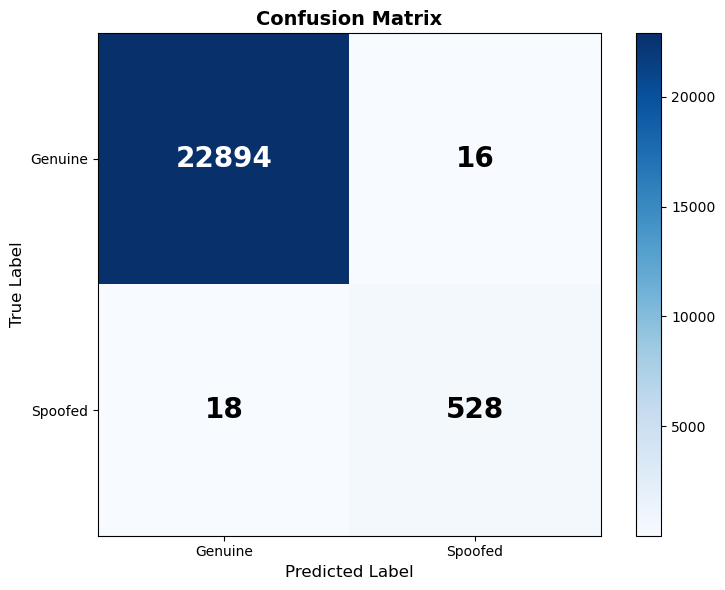


Detailed Classification Report:
              precision    recall  f1-score   support

     Genuine       1.00      1.00      1.00     22910
     Spoofed       0.97      0.97      0.97       546

    accuracy                           1.00     23456
   macro avg       0.98      0.98      0.98     23456
weighted avg       1.00      1.00      1.00     23456


Confusion matrix saved to: models\confusion_matrix.png


In [39]:
# Confusion matrix and classification report
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, cmap='Blues')

# Labels
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Genuine', 'Spoofed'])
ax.set_yticklabels(['Genuine', 'Spoofed'])

# Annotations
for i in range(2):
    for j in range(2):
        text = ax.text(j, i, cm[i, j], ha="center", va="center", 
                      color="white" if cm[i, j] > cm.max() / 2 else "black",
                      fontsize=20, fontweight='bold')

ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
ax.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.savefig(output_root / 'confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Classification report
print(f"\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Genuine', 'Spoofed']))

print(f"\nConfusion matrix saved to: {output_root / 'confusion_matrix.png'}")

## 7. Spoofing Detection on Real Incidents

Apply Algorithm 3 to detect spoofed points in actual incident trajectories.

In [45]:
# # Detect spoofed points in real AIS data (Algorithm 3 implementation)
# def detect_spoofing_in_data(model, df, feature_cols, scaler, sequence_length=128, threshold=0.6):
#     """
#     Apply trained model to detect spoofed AIS messages in real data.
    
#     Returns:
#         DataFrame with anomaly scores and predictions
#     """
#     # Prepare features
#     df_featured, _ = extract_features(df.copy())
#     df_normalized, _ = normalize_features(df_featured, feature_cols, fit_scaler=False, scaler=scaler)
    
#     # Create sequences per vessel
#     results = []
    
#     for vessel_id, vessel_data in df_normalized.groupby('vessel_id'):
#         vessel_data = vessel_data.sort_values('timestamp')
#         features = vessel_data[feature_cols].values
        
#         if len(features) < sequence_length:
#             # Skip vessels with insufficient data
#             continue
        
#         # Create overlapping windows
#         for i in range(len(features) - sequence_length + 1):
#             seq = features[i:i+sequence_length]
#             seq = seq.reshape(1, sequence_length, len(feature_cols))
            
#             # Predict anomaly score
#             score = model.predict(seq, verbose=0)[0][0]
            
#             # Store result for middle point of sequence
#             mid_idx = i + sequence_length // 2
#             if mid_idx < len(vessel_data):
#                 row = vessel_data.iloc[mid_idx].copy()
#                 row['anomaly_score'] = score
#                 row['is_spoofed'] = 1 if score > threshold else 0
#                 results.append(row)
    
#     if not results:
#         return None
    
#     results_df = pd.DataFrame(results)
#     print("Spoofing Detection Results:")
#     print(f"  Total points analyzed: {len(results_df):,}")
#     print(
#         f"  Detected spoofed: "
#         f"{(results_df['is_spoofed'] == 1).sum():,} "
#         f"({(results_df['is_spoofed'] == 1).sum() / len(results_df) * 100:.1f}%)"
#     )
#     print(f"  Mean anomaly score: {results_df['anomaly_score'].mean():.3f}")
#     print(f"  Max anomaly score: {results_df['anomaly_score'].max():.3f}")

#     return results_df
    

In [43]:
# # Detect spoofed points in a specific incident (Algorithm 3 implementation)
# def detect_spoofing_in_incident(incident_name, model, feature_scaler, feature_cols, 
#                                  threshold=0.6, sequence_length=128):
#     """
#     Apply spoofing detection to a specific incident.
    
#     Returns dataframe with anomaly scores for each AIS message.
#     """
#     # Load incident data
#     inc = next((i for i in incidents if i["name"] == incident_name), None)
#     if inc is None:
#         print(f"❌ Incident '{incident_name}' not found")
#         return None
    
#     slice_path = data_root / inc["slug"] / "slice.parquet"
#     if not slice_path.exists():
#         print(f"❌ Data not found: {slice_path}")
#         return None
    
#     # Load and preprocess
#     df = pd.read_parquet(slice_path)
#     df = clean_ais_data(df)
    
#     # Extract and normalize features
#     df, _ = extract_features(df)
#     df, _ = normalize_features(df, feature_cols, fit_scaler=False, scaler=feature_scaler)
    
#     # Create sequences per vessel
#     anomaly_scores = []
    
#     for vessel_id, vessel_data in df.groupby('vessel_id'):
#         vessel_data = vessel_data.sort_values('timestamp')
#         features = vessel_data[feature_cols].values
        
#         if len(features) < sequence_length:
#             # For short trajectories, use available length
#             seq = features
#             if len(seq) < 10:
#                 continue
#             # Pad if needed
#             if len(seq) < sequence_length:
#                 pad_length = sequence_length - len(seq)
#                 seq = np.vstack([seq, np.zeros((pad_length, seq.shape[1]))])
#         else:
#             # Use sliding window
#             seq = features[:sequence_length]
        
#         # Predict
#         seq_reshaped = seq.reshape(1, sequence_length, -1)
#         score = model.predict(seq_reshaped, verbose=0)[0][0]
        
#         # Store scores for all points in this vessel
#         for idx in vessel_data.index:
#             anomaly_scores.append({
#                 'index': idx,
#                 'vessel_id': vessel_id,
#                 'anomaly_score': score,
#                 'is_spoofed': int(score > threshold)
#             })
    
#     # Merge with original data
#     scores_df = pd.DataFrame(anomaly_scores)
#     df_with_scores = df.merge(scores_df, left_index=True, right_on='index', how='left')
    
#     return df_with_scores

# # Test on Agia Zoni II incident
# print(" Detecting spoofing in Agia Zoni II incident...\n")
# incident_results = detect_spoofing_in_incident(
#     "Agia Zoni II", 
#     model, 
#     feature_scaler, 
#     feature_cols,
#     threshold=THRESHOLD
# )

# if incident_results is not None:
#     print(f"✓ Detection complete for Agia Zoni II")
#     print(f"   Total AIS messages: {len(incident_results)}")
#     print(f"   Detected spoofed: {incident_results['is_spoofed'].sum()}")
#     print(f"   Detection rate: {incident_results['is_spoofed'].sum() / len(incident_results) * 100:.2f}%")
#     print(f"\n   Anomaly score statistics:")
#     print(f"   Mean: {incident_results['anomaly_score'].mean():.4f}")
#     print(f"   Std:  {incident_results['anomaly_score'].std():.4f}")
#     print(f"   Max:  {incident_results['anomaly_score'].max():.4f}")
#     print(f"   Min:  {incident_results['anomaly_score'].min():.4f}")

In [44]:
# # Visualize detected spoofing on map
# if incident_results is not None:
#     inc = next((i for i in incidents if i["name"] == "Agia Zoni II"), None)
#     lat0, lon0 = inc["approx_lat"], inc["approx_lon"]
    
#     # Create map
#     m = folium.Map(
#         location=[lat0, lon0],
#         zoom_start=12,
#         tiles="CartoDB positron"
#     )
    
#     # Feature groups
#     fg_genuine = folium.FeatureGroup(name="Genuine AIS", show=True)
#     fg_spoofed = folium.FeatureGroup(name="Detected Spoofed", show=True)
#     fg_incident = folium.FeatureGroup(name="Incident Location", show=True)
    
#     # Plot trajectories by vessel and spoofing status
#     for vessel_id, vessel_data in incident_results.groupby('vessel_id_x'):
#         vessel_data = vessel_data.sort_values('timestamp')
        
#         # Split into genuine and spoofed segments
#         genuine = vessel_data[vessel_data['is_spoofed'] == 0]
#         spoofed = vessel_data[vessel_data['is_spoofed'] == 1]
        
#         # Genuine trajectory (blue)
#         if len(genuine) > 1:
#             coords_genuine = genuine[['lat', 'lon']].values.tolist()
#             folium.PolyLine(
#                 coords_genuine, 
#                 color='blue', 
#                 weight=2, 
#                 opacity=0.7,
#                 tooltip=f"Vessel {vessel_id} (Genuine)"
#             ).add_to(fg_genuine)
        
#         # Spoofed points (red)
#         if len(spoofed) > 0:
#             for idx, row in spoofed.iterrows():
#                 folium.CircleMarker(
#                     location=[row['lat'], row['lon']],
#                     radius=6,
#                     color='red',
#                     fill=True,
#                     fillColor='red',
#                     fillOpacity=0.8,
#                     popup=f"Spoofed<br>Score: {row['anomaly_score']:.3f}<br>Vessel: {vessel_id}",
#                     tooltip="Detected Spoofing"
#                 ).add_to(fg_spoofed)
    
#     # Mark incident location
#     folium.Marker(
#         location=[lat0, lon0],
#         popup=f"<b>Agia Zoni II Incident</b><br>2017-09-10",
#         icon=folium.Icon(color="red", icon="exclamation", prefix="fa"),
#         tooltip="Incident Location"
#     ).add_to(fg_incident)
    
#     # Add layers
#     fg_genuine.add_to(m)
#     fg_spoofed.add_to(m)
#     fg_incident.add_to(m)
#     folium.LayerControl().add_to(m)
    
#     print(f"  Spoofing detection map created")
#     display(m)

## 8. Model Export & Summary

Save trained model, scaler, and configuration for deployment.

In [ ]:
# # Save model artifacts
# import pickle

# # Save PyTorch model
# model_path = output_root / 'best_bilstm_model.pt'
# torch.save(model.state_dict(), model_path)

# # Save scaler
# scaler_path = output_root / 'feature_scaler.pkl'
# with open(scaler_path, 'wb') as f:
#     pickle.dump(feature_scaler, f)

# # Save configuration
# config = {
#     'feature_cols': feature_cols,
#     'sequence_length': SEQUENCE_LENGTH,
#     'threshold': THRESHOLD,
#     'lstm_units_1': 62,
#     'lstm_units_2': 30,
#     'learning_rate': LEARNING_RATE,
#     'batch_size': BATCH_SIZE,
#     'input_size': X_train.shape[2],
#     'test_metrics': {
#         'precision': float(precision),
#         'recall': float(recall),
#         'f1_score': float(f1),
#         'detection_rate': float(detection_rate),
#         'accuracy': float(test_acc)
#     }
# }

# config_path = output_root / 'model_config.pkl'
# with open(config_path, 'wb') as f:
#     pickle.dump(config, f)

# print(f"Model Artifacts Saved:")
# print(f"  Model: {model_path}")
# print(f"  Scaler: {scaler_path}")
# print(f"  Config: {config_path}")

# print(f"\n" + "="*60)
# print(f"Bi-LSTM SPOOFING DETECTION - PYTORCH IMPLEMENTATION COMPLETE")
# print(f"="*60)
# print(f"\nFinal Test Set Performance:")
# print(f"  Precision:      {precision:.4f}")
# print(f"  Recall:         {recall:.4f}")
# print(f"  F1-Score:       {f1:.4f}")
# print(f"  Detection Rate: {detection_rate:.4f}")
# print(f"  Accuracy:       {test_acc:.4f}")

# print(f"\nComparison with Paper (Bi-LSTM):")
# print(f"  Precision:      Paper: 0.94, Ours: {precision:.2f}")
# print(f"  Recall:         Paper: 0.92, Ours: {recall:.2f}")
# print(f"  F1-Score:       Paper: 0.93, Ours: {f1:.2f}")
# print(f"  Detection Rate: Paper: 0.91, Ours: {detection_rate:.2f}")

# print(f"\nNext Steps:")
# print(f"  1. Apply to all 5 maritime incidents")
# print(f"  2. Fine-tune threshold τ for production use")
# print(f"  3. Integrate with TimeFM for trajectory forecasting")
# print(f"  4. Deploy for real-time AIS stream processing")
# print(f"="*60)